Imports

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

from scipy.spatial.distance import cdist
from scipy.linalg import pinv
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.optim as optim

import os
import pickle

import importlib
import src
from src.dataset import info, check
importlib.reload(src)

X_train, X_test, y_train, y_test, scaler_X, scaler_y = src.dataset.load_split_data(one_speed=True, all_features=True)
# check(X_train, "np", (1280004, 6)) # For all speeds
# check(y_train, "np", (1280004, 3))
# check(X_train, "np", (256000, 6)) # For one speed
# check(y_train, "np", (256000, 3))
# check(X_test, "np", (320001, 6))
# check(y_test, "np", (320001, 3))
# check(X_test, "np", (64001, 6))
# check(y_test, "np", (64001, 3))

check(X_train, "np", (256000, 18)) # For one speed, all features
check(y_train, "np", (256000, 3))
check(X_test, "np", (64001, 18))
check(y_test, "np", (64001, 3))

Python random seed set.
NumPy random seed set.
PyTorch random seed set.
Python random seed set.
NumPy random seed set.
PyTorch random seed set.
Loaded from pickle


Model setup

In [2]:
class RBFN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, centers, sigma):
        super(RBFN, self).__init__()
        self.centers = centers.reshape(-1, centers.shape[-1])
        self.sigma = sigma

        # Define layers
        self.layers = nn.ModuleList()
        # prev_size = input_size
        prev_size = centers.shape[0] # The number of centers
        
        # Add hidden layers
        for hidden_size in hidden_sizes:
            self.layers.append(nn.Linear(prev_size, hidden_size))
            self.layers.append(nn.ReLU())  # Add activation function
            prev_size = hidden_size
        
        # Add output layer
        self.output_layer = nn.Linear(prev_size, output_size)
    
    def _rbf(self, X):
        distances = cdist(X, self.centers, 'euclidean')
        distances_rbf = np.exp(-distances ** 2 / (2 * self.sigma ** 2))
        return torch.from_numpy(distances_rbf).float()

    def forward(self, x):
        x = self._rbf(x)
        # Apply each hidden layer
        for layer in self.layers:
            x = layer(x)

        # Apply output layer
        x = self.output_layer(x)
        return x


In [3]:
sigma = 1
num_centers = 90

# random_indices = np.random.choice(X_train.shape[0], num_centers, replace=False)
# centers = X_train[random_indices, :]
kmeans = KMeans(n_clusters=num_centers, n_init=10, random_state=0)
kmeans.fit(X_train)
centers = kmeans.cluster_centers_ # The cluster centers will serve as the RBF centers

model = RBFN(len(X_train[0]), [], 1, centers, sigma)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

/Users/hugojohnson/.virtualenvs/02456-deep-learning-project/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [4]:
myOut = model._rbf(X_test)
print(myOut.shape)

torch.Size([64001, 90])


In [5]:
# Example training loop
epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients

    outputs = model(torch.from_numpy(X_train).float())  # Forward pass
    loss = criterion(outputs, torch.from_numpy(y_train[:, 0].reshape(-1, 1)).float())  # Compute loss

    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")


Epoch 1/500, Loss: 0.04030243307352066
Epoch 2/500, Loss: 0.3383826017379761
Epoch 3/500, Loss: 0.0527934655547142
Epoch 4/500, Loss: 0.11069139838218689
Epoch 5/500, Loss: 0.20826691389083862
Epoch 6/500, Loss: 0.14411790668964386
Epoch 7/500, Loss: 0.05081266537308693
Epoch 8/500, Loss: 0.036908216774463654
Epoch 9/500, Loss: 0.08866775780916214
Epoch 10/500, Loss: 0.1178859993815422
Epoch 11/500, Loss: 0.08991548418998718
Epoch 12/500, Loss: 0.043191444128751755
Epoch 13/500, Loss: 0.02509034052491188
Epoch 14/500, Loss: 0.044086698442697525
Epoch 15/500, Loss: 0.06819074600934982
Epoch 16/500, Loss: 0.06683476269245148
Epoch 17/500, Loss: 0.04316774010658264
Epoch 18/500, Loss: 0.02246122434735298
Epoch 19/500, Loss: 0.022394448518753052
Epoch 20/500, Loss: 0.03665612265467644
Epoch 21/500, Loss: 0.04514399170875549
Epoch 22/500, Loss: 0.037696968764066696
Epoch 23/500, Loss: 0.0228956900537014
Epoch 24/500, Loss: 0.015580380335450172
Epoch 25/500, Loss: 0.020410388708114624
Epoch 

-----
-----
Mean Squared Error: 0.00461523188278079


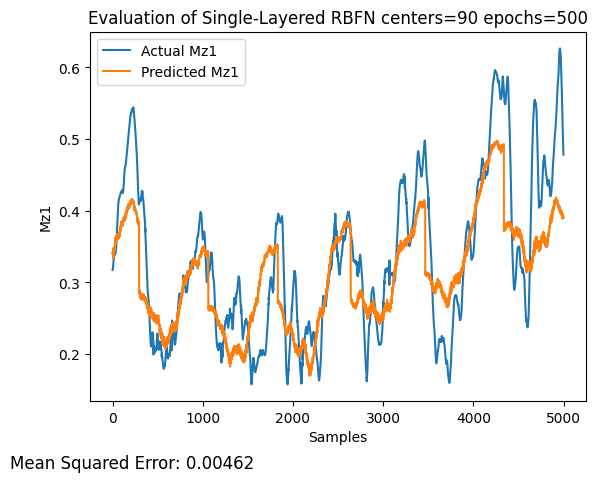

In [9]:
y_pred = model.forward(torch.from_numpy(X_test).float())
info(y_pred)

# Print the loss
print("Mean Squared Error:", loss.item())

start = 10000
src.plots.evaluate_predictions(y_pred.detach().numpy()[start:start+5000], y_test[:, 0][start:start+5000], loss.item(), name=f"Single-Layered RBFN centers={len(centers)} epochs={epochs}")

In [10]:
# Convert the tensor to a NumPy array
numpy_array = y_pred.detach().numpy()
# Convert the NumPy array to a DataFrame
df = pd.DataFrame(numpy_array)
# Save the DataFrame to a CSV file
df.to_csv('tensor_data.csv', index=False)